# INSIGHT DATA SCIENCE FELLOWS

**The INSIGHT Data Science Fellows Program** is very competitive fellowship targeted at academics from the top universities. It helps recent PhDs and Postdocs to find a prestigious job as data scientists in the industry. 


I was really curious about **who are these top 'quants'**. So I scraped the data from the INSIGHT website and did some quick EDA. Here's my script:

In [3]:
from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from collections import Counter

%matplotlib inline

# PART 1: Scraping Data

In [119]:
project = []
company = []
position = []
background = []
name = []

In [120]:
url = 'https://www.insightdatascience.com/fellows?61ea5d1b_page=%s'
for idx in range(1, 9):
    print(f'fill scrap - {url % idx}')
    result = requests.get(url % idx)
    content = result.content
    
    soup = BeautifulSoup(content)
    project_per_page = [x.get_text() for x in soup.find_all("div", "tooltip_project")]
    project.extend(project_per_page)
    company.extend([x.get_text() for x in soup.find_all("div", "tooltip_company")])
    position.extend([x.get_text() for x in soup.find_all("div", "toottip_title")])
    name.extend([x.get_text() for x in soup.find_all("div", "tooltip_name")])
    background.extend([x.get_text() for x in soup.find_all("div", "tooltip_background")])
    
    print(result.status_code)
    print(project_per_page[0])

fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=1
200
Measuring the Impact of Open Source Coders on Github
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=2
200
StreetsAhead: Image recognition with deep learning in Street View
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=3
200
ATHOS gear: Logging your workout with wearable EMG techology
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=4
200
GoodReviews: Deliver the most useful positive and negative book reviews
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=5
200
DealWheels: Used Cars Online-Great deal?
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=6
200
L' Tron - CTA: A Friendly Bot with an Eye on Chicago's 'L'
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=7
200
Fleetr
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=8
200
SignWrite: Transcribing sign lang

In [612]:
# create tuples out of 4 features
zipped = np.array(list(zip(name, company, project, position, background)))

In [613]:
insight = pd.DataFrame(np.array(zipped), columns=['name', 'company', 'project', 'position', 'background'])

In [614]:
insight.head()

,name,company,project,position,background
0,JP Bida,Capital One,Measuring the Impact of Open Source Coders on Github,Director of Risk,"Bio-X Games, Stanford, Postdoc"
1,Douglas Mason,Twitter,Email Searcher: Search & Visualize Your Mailbox,Data Scientist,"Physics, Harvard University, PhD\n"
2,Virot Ta Chiraphadhanakul,Facebook,Tweet Timeline: Visualizing the Impact of Social Media,Data Scientist,"Operations Research, MIT, PhD"
3,Julia Viladomat,Adobe,Sentiment Analysis Based on Social Media,Data Scientist,"Statistics, Stanford, Postdoc"
4,David Freeman,LinkedIn,Flight Delay Predictor,Head of Anti-Abuse Engineering,"Mathematics, Stanford, Postdoc"


In [124]:
insight.shape

(794, 5)

Some company names were parsed incorrectly. I created json file with correct codes:

In [647]:
with open('assets/company_codes_correct.json', 'r+') as file:
    company_codes = json.load(file)

In [635]:
insight['company'] = insight['company'].replace(codes)

Adding the new features 'University', 'Field', 'Postdoc' extracted from Background:

In [ ]:
background2 = []
for i in range(insight['background'].shape[0]):
    bckgr2 = [x.strip() for x in insight['background'][i].split(',')]
    background2.append(bckgr2)

In [652]:
university = []
field = []
postdoc = []

for i in range(len(background2)):
    if len(background2[i]) > 2:
        fld = background2[i][0]
        uni = background2[i][1]
        psdc = background2[i][2]
        university.append(uni)
        field.append(fld)
        postdoc.append(psdc)
    else:
        university.append("")
        field.append("")
        postdoc.append("")

In [653]:
insight['university'] = university
insight['field'] = field
insight['postdoc'] = postdoc

Some uni names were parsed incorrectly. I created json file with correct codes:

In [704]:
with open('assets/university_codes_correct.json', 'r+') as file:
    uni_codes = json.load(file)

In [705]:
insight['university'] = insight['university'].replace(uni_codes)

In [706]:
insight.head()

,name,company,project,position,background,university,field,postdoc
0,JP Bida,Capital One,Measuring the Impact of Open Source Coders on Github,Director of Risk,"Bio-X Games, Stanford, Postdoc",Stanford,Bio-X Games,Postdoc
1,Douglas Mason,Twitter,Email Searcher: Search & Visualize Your Mailbox,Data Scientist,"Physics, Harvard University, PhD\n",Harvard,Physics,PhD
2,Virot Ta Chiraphadhanakul,Facebook,Tweet Timeline: Visualizing the Impact of Social Media,Data Scientist,"Operations Research, MIT, PhD",MIT,Operations Research,PhD
3,Julia Viladomat,Adobe,Sentiment Analysis Based on Social Media,Data Scientist,"Statistics, Stanford, Postdoc",Stanford,Statistics,Postdoc
4,David Freeman,LinkedIn,Flight Delay Predictor,Head of Anti-Abuse Engineering,"Mathematics, Stanford, Postdoc",Stanford,Mathematics,Postdoc


In [759]:
# Saving scraped dataset to csv file:
insight.to_csv(path_or_buf='data/insight_dataset.csv', sep=';', index=False)

## Summary: 

The final dataset has 794 observations (i.e. so many fellows participated in the INSIGHT Data Science Fellowship as of 04/21/2019) and 5 features:
1. Name
2. Company
3. Project
4. Position
5. Background 
6. University
7. (Academic) Field

NOTE: some fields that were generated from 'background' were parsed badly because I split the string into words by commas, because of the pattern used by the INSIGHT admins - "field, university, graduate degree". For most cases that worked. But some have a different formatting style (e.g. - "long field with many commas, university, graduate degree"). As a result, there are about 22 data points without any university affiliations. 

So I manually corrected the mistakes and saved it to 'insight_dataset_cleaned.csv' file, which is then loaded in the PART 2.



# PART 2: ANALYSIS

In [4]:
insight = pd.read_csv('data/insight_dataset_cleaned.csv', sep=';')

In [19]:
insight.shape

(794, 8)

In [5]:
insight.head()

,name,company,project,position,background,university,field,postdoc
0,JP Bida,Capital One,Measuring the Impact of Open Source Coders on ...,Director of Risk,"Bio-X Games, Stanford, Postdoc",Stanford,Bio-X Games,Postdoc
1,Douglas Mason,Twitter,Email Searcher: Search & Visualize Your Mailbox,Data Scientist,"Physics, Harvard University, PhD\n",Harvard,Physics,PhD
2,Virot Ta Chiraphadhanakul,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Data Scientist,"Operations Research, MIT, PhD",MIT,Operations Research,PhD
3,Julia Viladomat,Adobe,Sentiment Analysis Based on Social Media,Data Scientist,"Statistics, Stanford, Postdoc",Stanford,Statistics,Postdoc
4,David Freeman,LinkedIn,Flight Delay Predictor,Head of Anti-Abuse Engineering,"Mathematics, Stanford, Postdoc",Stanford,Mathematics,Postdoc


## 2.1. COMPANIES:

In [7]:
companies = insight['company'].unique()

In [8]:
#how many companies?
len(companies)

383

In [9]:
company_num = [insight['company'][insight['company'] == companies[i]].count() for i in range(len(companies))]

In [10]:
companies_count = pd.DataFrame({'company': companies, 'company_num': company_num})

In [11]:
companies_count = companies_count.sort_values(by='company_num', ascending=False)
companies_count = companies_count.reset_index()
companies_count.head(10)

,index,company,company_num
0,2,Facebook,54
1,4,LinkedIn,22
2,32,Stitch Fix,19
3,6,Netflix,15
4,42,Intuit,14
5,35,Insight Data Science,13
6,37,Yelp,12
7,183,Gartner,12
8,13,Uber,12
9,147,Schireson,11


In [789]:
print("{} fellows work in top10 companies which is {:.2f}%".format(companies_count.head(10).company_num.sum(), 100*companies_count.head(10).company_num.sum()/insight.shape[0]))

184 fellows work in top10 companies which is 23.17%


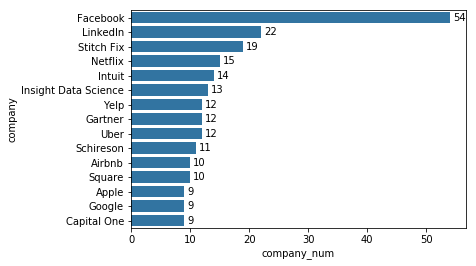

In [676]:
base_color = sns.color_palette()[0]

sns.barplot(y = companies_count.company[:15], x = companies_count.company_num[:15], color=base_color);
for i in range(15):
    #X position just after the end of the bar:
    count = companies_count['company_num'][i]
    plt.text(count+0.5, i, count, va = 'center');

In [805]:
print("{} companies hired just 1 fellow which is {:.2f}% of all companies".format(
    companies_count.company_num[companies_count.company_num == 1].count(),
    100*companies_count.company_num[companies_count.company_num == 1].count()/len(companies)))

275 companies hired just 1 fellow which is 71.80% of all companies


## Summary:
There are 383 companies where INSIGHT fellows started working. However, there are no strong patterns where fellows find jobs, since 71% of companies hired just 1 fellow. <br>

Still, 23.17% of all fellows work in the top10 companies. <br>

The top 5 companies that hire actively data scientists are Facebook (54 fellows), LinkedIn (22), Stich Fix (19), Netflix (15) and Intuit (14). All five are in the Silicon Valley, where the demand for Data Scientist is naturally the highest.



## 2.2. UNIVERSITIES:

In [791]:
uni_unique = insight['university'].unique()
print("fellows come from {} different universities".format(len(uni_unique)))

fellows come from 214 different universities


In [685]:
uni_num = [insight['university'][insight['university'] == uni_unique[i]].count() for i in range(len(uni_unique))]

In [686]:
uni_count = pd.DataFrame({'university': uni_unique, 'university_num': uni_num})

In [687]:
uni_count = uni_count.sort_values(by='university_num', ascending=False)
uni_count = uni_count.reset_index()

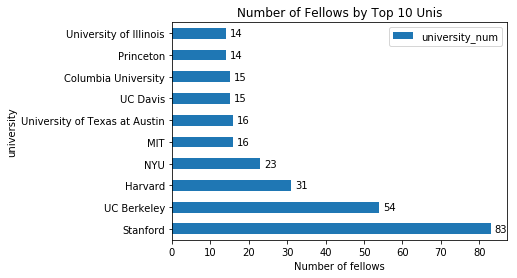

In [795]:
uni_count.head(10).plot.barh(x = 'university', y = 'university_num');
plt.xlabel('Number of fellows')
plt.title('Number of Fellows by Top 10 Unis');
for i in range(10):
    #X position just after the end of the bar:
    count = uni_count['university_num'][i]
    plt.text(count+1, i, count, va = 'center');

In [796]:
print("top10 universities account for {} fellows which is {:.2f}%".format(uni_count.head(10).university_num.sum(), 
                                                                          100*uni_count.head(10).university_num.sum()/insight.shape[0]))

top10 universities account for 281 fellows which is 35.39%


## Summary:

The 794 INSIGHT Fellows come from 214 different universities - very diverse!  <BR> 
    
However, 35% of all fellows come from just 10 universities. Moreover, almost 20% of fellows (152) are from the three Californian universities - Stanford, UC Berkeley and UC Davis. The pattern is not suprising given the insight from the previous step - namely that it is primarily Silicon Valley companies that hire DS fellows the most. <br>
    
The top 5 universities that convert PhDs to data scientists are Stanford (83 fellows), UC Berkeley (54), Harvard (31), NYU (23) and MIT (16).

## 2.3. ACADEMIC FIELD:

In [691]:
fields = ['Physics', 'Chemistry', 'Biology', 'Statistics', 'Mathematic', 'Mechanical Engineering',
          'Astrophysics', 'Neuroscience', 'Genetics', 'Biophysics', 'Biochemistry','Psychology', 'Ecology', 'Politic',
         'Linguistics', 'Computer Science', 'Environment','Astronomy', 'Biomedical Engineering', 'Bioinformatics',
         'Electrical Engineering', 'Biostatistics']
fields_num = []

for each in fields:
    fields_nb = insight['university'][insight['background'].str.contains(each)].count()
    fields_num.append(fields_nb)
result = list(zip(fields, fields_num))

In [722]:
fields = pd.DataFrame(data=result, columns=['fields', 'fields_num'])
fields = fields.sort_values(by='fields_num', ascending=False)
fields['fields_pct'] = round(100*fields['fields_num']/insight.shape[0], 2)
fields

,fields,fields_num,fields_pct
0,Physics,187,23.55
7,Neuroscience,79,9.95
6,Astrophysics,67,8.44
4,Mathematic,59,7.43
2,Biology,46,5.79
9,Biophysics,22,2.77
11,Psychology,19,2.39
16,Environment,17,2.14
17,Astronomy,17,2.14
18,Biomedical Engineering,16,2.02


In [693]:
# % of all insight fellows covered by above fields 
round(100*fields.fields_num.sum()/insight.shape[0], 2)

82.37

### Fellows from Political Science (like me :) 

In [20]:
insight[insight['background'].str.contains('Econ')]

,name,company,project,position,background,university,field,postdoc
140,Alex Ruiz-Euler,Viacom,Yelper Helper: An engine for tailored Yelp Reviews,"Senior Data Scientist, Audience Science","Political Economy, UCSD, PhD",UC San Diego,Political Economy,PhD
179,Alex Groves,CreativeLive,How To Strike: Optimizing a directed e-mail campaign,Data Scientist,"Behavioral Economics, ECARES, ULB, Postdoc",ECARES ULB,Behavioral Economics,Postdoc
434,Patrick Doupe,Arnhold Institute (Mount Sinai),LANDSAT-landstats: A population measure you can count on.,Senior Data Analyst,"Economics, Potsdam Institute for Climate Impact Research, Postdoc",Potsdam Institute for Climate Impact Research,Economics,Postdoc
536,Peter Twieg,Intuit,Coming To Terms: Recommending optimal loan terms for crowdfunded projects,Data Scientist,"Economics, George Mason University, PhD",George Mason University,Economics,PhD
591,Jen Steele,Facebook,Freight Rate,Data Scientist,"Economics, University of Auckland, Assistant Professor",University of Auckland,Economics,Assistant Professor
636,Jenny Lin,Yelp,pigiback,Data Scientist,"Economics, University of Michigan, PhD",University of Michigan,Economics,PhD
683,Toban Wiebe,Prosper,Find Your Commmunity,Data Scientist,"Economics, University of Pennsylvania, PhD",University of Pennsylvania,Economics,PhD
761,Di Mo,LinkedIn,Startup Telescope: Future is now,Data Scientist,"Economics, Stanford University, Research Associate",Stanford,Economics,Research Associate


## Summary:

The majority of fellows are freshly completed PhDs - 64%. There are about 29% postdocs among the INSIGHT fellows. But there is also a small amount of practitioners (uni faculty, manager, researchers). <br>
Almost every third comes from Physics/Astrophysics (32%). The next biggest group - 10% - are neuroscientists. <br>
Among 794 fellows, only 9 have graduated degree in political science!



## 2.4. PhD vs Postdoc

In [807]:
#how many PhDs?
print('{} fellows are fresh PhDs...'.format(insight.postdoc[insight['postdoc'] =='PhD'].count()))

507 fellows are fresh PhDs


In [809]:
#how many postdocs?
print('...compared to {} fellows that are Postdocs'.format(insight.postdoc[insight['postdoc'] =='Postdoc'].count()))

...compared to 227 fellows that are Postdocs


In [813]:
# distribution
print('so distribution is as follows: {:.1f}% postdocs and {:.1f}% PhDs'.format(
    100*insight.postdoc[insight['postdoc'] =='Postdoc'].count()/insight.shape[0],
    100*insight.postdoc[insight['postdoc'] =='PhD'].count()/insight.shape[0]))

so distribution is as follows: 28.6% postdocs and 63.9% PhDs


## Top10 companies

In [12]:
top10_companies = insight.company[insight['company'].isin(companies_count.company.head(10))]
pd.crosstab(top10_companies, insight.postdoc, margins=True).T

company,Facebook,Gartner,Insight Data Science,Intuit,LinkedIn,Netflix,Schireson,Stitch Fix,Uber,Yelp,All
postdoc,,,,,,,,,,,
Assistant Professor,1,0,0,0,0,0,0,0,0,0,1
Associate Research Scientist,0,0,0,0,0,0,1,0,0,0,1
PhD,33,7,9,11,11,10,5,13,9,8,116
Postdoc,18,4,4,3,10,4,4,5,2,4,58
Research Associate,1,0,0,0,1,0,0,0,0,0,2
Research Faculty,0,0,0,0,0,0,1,0,0,0,1
Research Scientist,0,0,0,0,0,1,0,0,0,0,1
Scientist,1,0,0,0,0,0,0,0,0,0,1
Staff,0,0,0,0,0,0,0,1,0,0,1


Commentary: It seems like top10 companies have almost equal predisposition when hiring postdocs (58/227=25.5%) and PhDs (116/507=22.9%). But we might whant to test if the difference is indeed statistically insignificant.


Interestingly, LinkedIn stands out from the rest 9 companies in that it hired disproportionally more postdocs compared to other top10 companies. <br>

So if you are the INSIGHT fellow and fresh PhD and want to go to LinkedIN - beware, there will be much more competition from more experienced collegues!

## Hypothesis Testing via Bootstrapping

### 1.  Do top10 companies hire more Postdocs than PhDs?

Let's check our hypothesis whether top10 compnies prefer to hire Postdocs rather than PhDs from Insight. We will do it via bootstrapping. Our "treatment" in this case is "top10 companies". So we divide our initial dataset into two groups - "top10" and "not top10" and compare the postdoc means for both groups. Then we bootstrap (resample with replacement) the data 10000 times and check if the difference between postdoc means for top10 group and not_top10 group is statistically significant. 

**H<sub>0</sub>**: top10 postdoc mean <= non_top10 postdoc mean <br>
**H<sub>1</sub>**: top10 postdoc mean > non_top10 postdoc mean

In [41]:
set(top10_companies)

{'Facebook',
 'Gartner',
 'Insight Data Science',
 'Intuit',
 'LinkedIn',
 'Netflix',
 'Schireson',
 'Stitch Fix',
 'Uber',
 'Yelp'}

In [76]:
#recode postdoc column to calc mean more quickly - 1 if postdoc
insight['postdoc_recoded'] = insight.postdoc.apply(lambda x: 1 if x == "Postdoc" else 0)
top10_insight.shape

(184, 9)

In [77]:
top10_insight = insight[insight.company.apply(lambda x: x in set(top10_companies)) == True]

In [78]:
#insight fellows not from top10_companies
not_top10_insight = insight[insight.company.apply(lambda x: x not in set(top10_companies)) == True]
not_top10_insight.shape

(610, 9)

In [79]:
top10_postdoc_mean = top10_insight.postdoc_recoded.mean()
top10_postdoc_mean

0.31521739130434784

In [80]:
not_top10_postdoc_mean = not_top10_insight.postdoc_recoded.mean()
not_top10_postdoc_mean

0.27704918032786885

In [82]:
obs_diff = top10_postdoc_mean - not_top10_postdoc_mean
obs_diff

0.03816821097647899

In [91]:
#create sampling distribution for difference in postdoc means with bootstrapping
diffs = []
for _ in range(10000):
    b_sample = insight.sample(insight.shape[0], replace=True)
    top10_insight = b_sample[b_sample.company.apply(lambda x: x in set(top10_companies)) == True]
    top10_postdoc_mean = top10_insight.postdoc_recoded.mean()
    not_top10_insight = b_sample[b_sample.company.apply(lambda x: x not in set(top10_companies)) == True]
    not_top10_postdoc_mean = not_top10_insight.postdoc_recoded.mean()
    diffs.append(top10_postdoc_mean - not_top10_postdoc_mean)

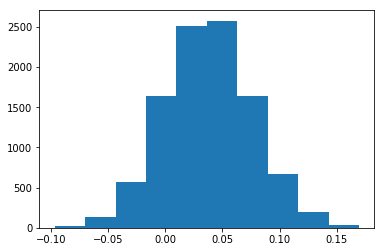

In [92]:
# convert to numpy array
diffs = np.array(diffs)
# plot distribution
plt.hist(diffs);

In [93]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

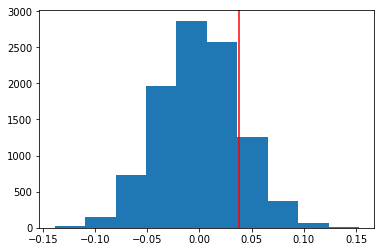

In [94]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(x=obs_diff, color = 'red');

In [95]:
# compute p value
(null_vals > obs_diff).mean()

0.1561

## Conclusion:
With a type I error rate of 0.05, we don't have evidence that the top10 companies prefer hiring postdocs over PhDs (p-value=0.1561). We have to retain H<sub>0</sub> hypothesis.

### 2. Does LinkedIN prefer to hire Postdocs over PhDs?

Now let's check our second hypothesis that LinkedIN prefer hiring postdocs over PhDs. We proceed in a similar fashion - dividing the initial dataset into two groups (linkedin/not_linkedin), finding the difference in postdoc means for both groups and then bootstrapping the data to see if the difference is statistically significance.

**H<sub>0</sub>**: linkedin_postdoc_mean <= non_linkedin postdoc mean <br>
**H<sub>1</sub>**: linkedin_postdoc_mean > non_linkedin postdoc mean

In [125]:
linkedin = insight[insight.company == "LinkedIn"]
linkedin_postdoc_mean = linkedin.postdoc_recoded.mean()
linkedin_postdoc_mean

0.45454545454545453

In [126]:
not_linkedin = insight[insight.company != "LinkedIn"]
not_linkedin_mean = not_linkedin.postdoc_recoded.mean()
not_linkedin_mean

0.2810880829015544

In [127]:
obs_diff = linkedin_postdoc_mean - not_linkedin_mean
obs_diff

0.17345737164390013

In [132]:
#create sampling distribution for difference in postdoc means with bootstrapping
diffs = []
for _ in range(10000):
    b_sample = insight.sample(insight.shape[0], replace=True)
    linkedin = b_sample[b_sample.company == "LinkedIn"]
    linkedin_postdoc_mean = linkedin.postdoc_recoded.mean()
    
    not_linkedin = b_sample[b_sample.company != "LinkedIn"]
    not_linkedin_mean = not_linkedin.postdoc_recoded.mean()
    diffs.append(linkedin_postdoc_mean - not_linkedin_mean)

In [133]:
# convert to numpy array
diffs = np.array(diffs)
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

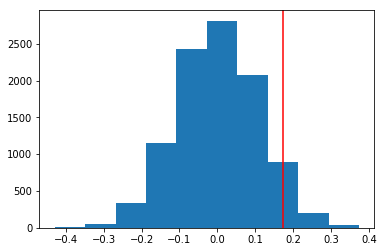

In [134]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(x=obs_diff, color = 'red');

In [135]:
# compute p value
(null_vals > obs_diff).mean()

0.053

## Conclusion:
Our p-value (0.0523) is slightly higher than alpha=0.05. So it's in the gray area of rejecting/retaining H0. However, the practical significance suggests that we may be ok with 5% error rate in our case and conclude that LinkedIn indeed prefer hiring Postdocs over PhDs, thus rejecting the H0 hypothesis.

## 2.5. PROJECTS by selected companies

Let's have a quick look at the projects by fellows that work at particular company:

In [188]:
pd.options.display.max_colwidth = 200

In [7]:
def show_projects_by_company(company):
    print(insight['project'][insight['company'] == company])

In [749]:
show_projects_by_company('Apple')

106                                                            Lenderstanding: Helping lenders help
116                         What's for Dinner: Dinner recommendations to meet daily nutrition goals
117                                                       AdNet: Graph recommender for news domains
306                                Now Looking for Players: Ditch the forums and find a friend fast
375                                             FindYourNextShow: A Local Live Music Discovery Tool
494    Businesses on Venmo are not your “friends”: Identify businesses posing as "friends" on Venmo
715                                               Movie Mash: Find a movie that everyone will enjoy
717               The key to a Joyful couple: Analyzing Customer Retention Through Clickstream Data
749                MatchTheVote: Matching advocacy group members with voters using machine learning
Name: project, dtype: object


In [750]:
show_projects_by_company('Netflix')

7                                CouchTube: YouTube TV shows in one click
14                 STARtrack: Helping Educators Track Student Performance
54                   InspectorGit: Discover Github's awesome repositories
78        OnLocation: How to see where your favorite movies were filmed. 
124                             Hoppr: Optimize route for running errands
191             UnicornHuntr: Predict the success of early-stage startups
249                        TLDR: The site for people that want more Karma
252              Next Best Store: Predict where your next store should be
329    Keyword Finder: Automatic keyword extraction- no alchemy required!
337       GitWatch: Revealing where to contribute to open source projects
406               The Great Divider: Sifting conversations about politics
638                                                       The Movie Model
675                                                          Hatched News
681                                   

**Summary**: from qualitative review of project titles for two companies, there seems to be no relation between the project and the company. How GitHub relates to Netflix?? I guess the more important thing is that you have your own project, what kind of project is secondary... <br>

But let's have a look at title projects as WordCloud. Maybe it will be more insightful?

## WordCloud of Project Title by Company

In [9]:
def show_wordcloud_of_projects_by_companies(company):
    subset = insight[insight['company']==company]
    text = " ".join(project for project in subset.project)
    # add stopwords
    stopwords = set(STOPWORDS)
    stopwords.update(["predicting", "data", "Finding", "Predict", "Search", "Find", 'make', 'Finder'])
    
    # plotting wordcloud
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords).generate(text)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

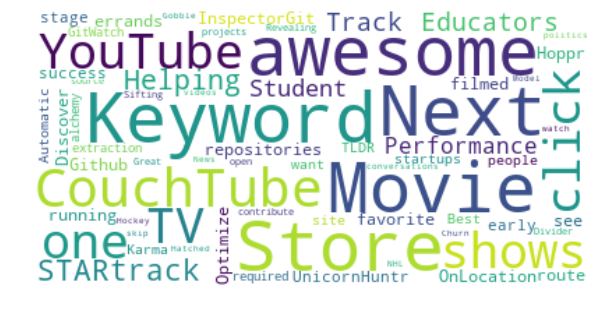

In [11]:
show_wordcloud_of_projects_by_companies('Netflix')

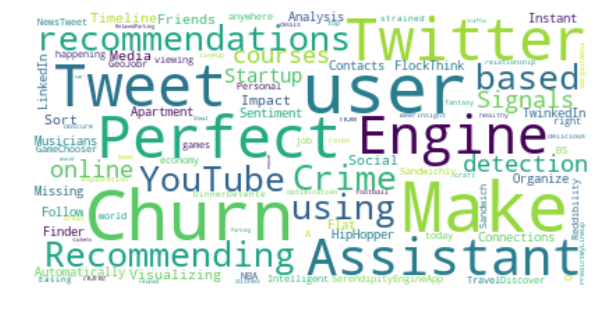

In [755]:
show_wordcloud_of_projects_by_companies('Facebook')

## Summary: 
Well, the WordCloud is a little bit more insightful than qualitative analysis. So, those fellows that ended up in Netflix had worked with videos (keywords - Movie, YouTube, TV, CouchTube), while those that got employed at Facebook had projects that deal with text (keywords - Tweet, Twitter) or with marketing (churn, user).

### Most common Words used in Project Titles:

In [15]:
pd.options.display.max_colwidth = 200

In [602]:
# join all project titles into one
all_text = " ".join(project for project in insight.project)
print ("There are {} words in all projects".format(len(text)))

There are 3068 words in all projects


In [603]:
# Cleaning text and lower casing all words
for char in '-.,\n':
    all_text = all_text.replace(char,' ')
all_text = all_text.lower()

# split returns a list of words delimited by sequences of whitespace (including tabs, newlines, etc, like re's \s) 
word_list = all_text.split()

In [608]:
# output a list of word count pairs (sorted from highest to lowest)
Counter(word_list).most_common()

[('the', 184),
 ('for', 125),
 ('a', 123),
 ('your', 120),
 ('to', 114),
 ('in', 86),
 ('find', 78),
 ('of', 75),
 ('and', 72),
 ('on', 69),
 ('predicting', 56),
 ('you', 50),
 ('with', 40),
 ('data', 31),
 ('new', 23),
 ('news', 23),
 ('finding', 22),
 ('based', 21),
 ('from', 21),
 ('time', 21),
 ('using', 21),
 ('will', 21),
 ('best', 20),
 ('predict', 18),
 ('helping', 17),
 ('that', 17),
 ('learning', 17),
 ('recommendations', 16),
 ('what', 16),
 ('how', 16),
 ('identifying', 16),
 ('search', 15),
 ('make', 15),
 ('discover', 15),
 ('an', 15),
 ('where', 15),
 ('at', 15),
 ('social', 14),
 ('next', 14),
 ('get', 13),
 ('twitter', 13),
 ('user', 13),
 ('music', 12),
 ('real', 12),
 ('is', 12),
 ('or', 12),
 ('by', 12),
 ('reviews', 11),
 ('out', 11),
 ('improving', 11),
 ('churn', 11),
 ('&', 10),
 ('predictor', 10),
 ('people', 10),
 ('app', 10),
 ('right', 10),
 ('recommender', 10),
 ('art', 10),
 ('it', 10),
 ('engagement', 10),
 ('they', 10),
 ('tool', 10),
 ('customer', 10),


Based on the list of the most common words (and ignoring the first 20 or so which are basically stopwords) we can now explore the content of the projects that we are interested using keywords:

In [13]:
def show_projects_using_keyword(keyword):
    print(insight['project'][insight['project'].str.contains(keyword)])

In [16]:
show_projects_using_keyword('YouTube')

7                                                                    CouchTube: YouTube TV shows in one click
52                                                                 NuTube: Classifying recent YouTube videos 
327    YouTube Matchmaker: Recommending Youtube channels with the same "IT" factor, using community detection
525                                               AboutFace: Identifying and tracking faces in YouTube videos
692                                                 BrandID: Detecting and identifying YouTube video sponsors
Name: project, dtype: object


In [746]:
show_projects_using_keyword('deep learning')

100        StreetsAhead: Image recognition with deep learning in Street View
700    SignWrite: Transcribing sign language with the power of deep learning
771                   Pic My Plant: Growing a garden rooted in deep learning
Name: project, dtype: object


# Conclusion:

This is a brief quick exploratory analysis of the INSIGHT Data Fellows - what background they have, where they come from, what projects they worked on and where they got jobs. One can test lots of hypothesis as the next step.

There are also other insteresting things to do & explore with the INSIGHT Fellowship:
 - The program has also other tracks besides Data Science like AI, Data Eng, Data PM, etc (see https://www.insightdatascience.com/fellows for the full list). like scraping all of the INSIGHT Fellows and check if there are different patterns compared to the DS track. 
 
 
 - Tracing the fellows on LinkedIn and checking how they are doing now - i.e. measuring the impact of the program. Are they still in DS? Do they change companies often? Do they hold senior positions now? etc.
 
 

# References:

INSIGHT Fellowship: https://www.insightdatascience.com/fellows

bradmontgomery/ShortIntroToScraping.rst, https://gist.github.com/bradmontgomery/1872970 (last access: 4/21/2019)


Michael Galarnyk: Python Word Count (Filter out Punctuation, Dictionary Manipulation, and Sorting Lists),
https://codeburst.io/python-basics-11-word-count-filter-out-punctuation-dictionary-manipulation-and-sorting-lists-3f6c55420855 (last access: 4/21/2019)

Duong Vu: Generating WordClouds in Python, https://www.datacamp.com/community/tutorials/wordcloud-python (last access: 4/21/2019)